In [3]:
import json
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau


import warnings
warnings.filterwarnings("ignore")

### 0. Data Preprocessing

In [4]:
df= pd.read_json('hinditrain.json')
df.head(5)

,text,value
0,बहुत ही मजेदार कहानी! 😂 #हंसी #मजाक,1
1,"आज का दिन बहुत खास है, क्योंकि आज मैंने अपने ख...",0
2,एक आदमी अपनी समस्याओं को दूसरों को बताएगा और द...,0
3,कभी कभी लोग इतना गहरा सोचते हैं कि उन्हें खुद ...,1
4,आज का टिप: समस्याएँ दूर करने का सबसे आसान तरीक...,0


In [5]:
df[df.value == 0].head(5)

,text,value
1,"आज का दिन बहुत खास है, क्योंकि आज मैंने अपने ख...",0
2,एक आदमी अपनी समस्याओं को दूसरों को बताएगा और द...,0
4,आज का टिप: समस्याएँ दूर करने का सबसे आसान तरीक...,0
5,"जब तक आप खुद से प्यार नहीं करते, तब तक आप दूसर...",0
6,"जिन्दगी एक रोलरकोस्टर है, कभी ऊपर, कभी नीचे, म...",0


In [6]:
df.value.value_counts()

1    53
0    39
Name: value, dtype: int64

In [7]:
df['text_len'] = df.text.apply(lambda x: len(x.split()))

In [8]:
sarcastic = df[df.value == 1]
legit = df[df.value == 0]

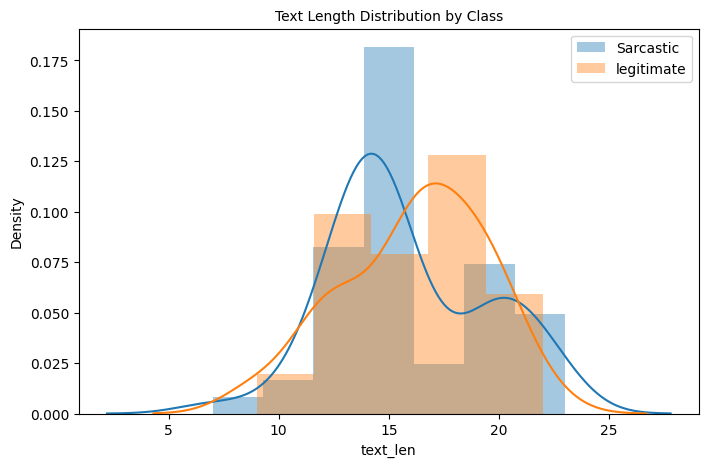

In [9]:
plt.figure(figsize=(8,5))
sns.distplot(sarcastic.text_len, hist= True, label= 'Sarcastic')
sns.distplot(legit.text_len, hist= True, label= 'legitimate')
plt.legend()
plt.title('Text Length Distribution by Class', fontsize = 10)
plt.show()

In [10]:
def clean_text(tweet):
    """
    This function receives a tweet and returns a clean sentence
    """
    tweet = tweet.lower()
    tweet = re.sub("\\n", "", tweet)

    # Split the tweet into words
    words = list(tweet.split())

    # Initialize WordNetLemmatizer
    lem = WordNetLemmatizer()

    # Lemmatize each word (assuming it's a verb, you can adjust the POS tag as needed)
    words = [lem.lemmatize(word, "v") for word in words]

    # Remove punctuations
    words = [w for w in words if w not in punctuations]

    # Optionally, remove stop words
    # words = [w for w in words if w not in stop_words]

    # Optionally, remove non-alphabetic characters
    # words = [''.join(x for x in w if x.isalpha()) for w in words]

    # Join the cleaned words back into a sentence
    clean_tweet = " ".join(words)

    return clean_tweet

In [11]:
# Install NLTK
!pip install nltk

# Import necessary libraries
import nltk
import urllib.request

# Download Hindi stopwords from GitHub
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-hi/master/stopwords-hi.txt"
stopwords_path = "/root/nltk_data/corpora/stopwords/hindi"

# Create the directory if it doesn't exist
!mkdir -p {stopwords_path}

# Download the stopwords file
urllib.request.urlretrieve(stopwords_url, f"{stopwords_path}/stopwords-hi.txt")

# Set the NLTK data directory
nltk.data.path = ['/root/nltk_data']

# Load Hindi stopwords from the downloaded file
with open(f"{stopwords_path}/stopwords-hi.txt", "r", encoding="utf-8") as file:
    hindi_stopwords = set(file.read().splitlines())

# Print the loaded stopwords
print(hindi_stopwords)


{'तिन्हें', 'जहां', 'इसके', 'ऱ्वासा', 'आप', 'कहते', 'किन्हें', 'बही', 'हुइ', 'होना', 'वाले', 'पहले', 'जा', 'से', 'हैं', 'बहि', 'बिलकुल', 'अभी', 'जब', 'ने', 'ना', 'की', 'जो', 'जेसे', 'लिये', 'इतयादि', 'रखें', 'दबारा', 'कोइ', 'दिया', 'उनके', 'कई', 'पर', 'उन', 'पे', 'वग़ैरह', 'तक', 'वहिं', 'मानो', 'वर्ग', 'काफ़ी', 'इत्यादि', 'ऐसे', 'हुई', 'उसे', 'तिसे', 'हे', 'इनका', 'तरह', 'तिंहों', 'दूसरे', 'था', 'यह', 'में', 'बाद', 'अपने', 'का', 'मे', 'उन्हों', 'काफि', 'किसि', 'जिंहें', 'दो', 'किया', 'जैसे', 'अपनी', 'भितर', 'होती', 'जिन्हों', 'कि', 'इसी', 'फिर', 'आदि', 'पूरा', 'उन्हीं', 'घर', 'हुआ', 'करने', 'इसे', 'यहि', 'रहे', 'जिन', 'भीतर', 'या', 'कइ', 'करना', 'वहाँ', 'नीचे', 'कर', 'थे', 'है', 'सकते', 'यिह', 'करता', 'एस', 'किस', 'पुरा', 'इसि', 'संग', 'साभ', 'रवासा', 'जिधर', 'किसे', 'जैसा', 'कोई', 'किन्हों', 'वह', 'इस', 'अभि', 'जहाँ', 'उनका', 'यदि', 'हुए', 'थी', 'जिंहों', 'तिंहें', 'बनी', 'यहाँ', 'वुह', 'उसके', 'रहा', 'उस', 'नहिं', 'सो', 'किंहों', 'कुछ', 'जीधर', 'एक', 'ही', 'उंहिं', 'और', 'किर', 'वहां',

In [12]:
import nltk
nltk.download('stopwords')
lem = WordNetLemmatizer()
stop_words = hindi_stopwords
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
df.groupby(['value']).text_len.mean()

value
0    16.153846
1    15.811321
Name: text_len, dtype: float64

In [14]:
df.groupby(['value']).text_len.max()

value
0    22
1    23
Name: text_len, dtype: int64

In [15]:
tweet = df['text']
labels = df['value']

In [16]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(tweet, labels, test_size=0.2, stratify=labels, random_state=42)

In [17]:
train_labels.value_counts()

1    42
0    31
Name: value, dtype: int64

In [18]:
max_words = 20000     # how many unique words to use (i.e num rows in embedding vector)
max_len = 60       # max number of words in a headline to use
oov_token = '<00V>'    # for the words which are not in training samples
padding_type = 'post'   # padding type
trunc_type = 'post'    # truncation for headlines longer than max length
embed_size = 64    # how big is each word vector

In [19]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

In [20]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [21]:
train_sequences

array([[ 6,  3, 40, ...,  0,  0,  0],
       [ 6,  3, 44, ...,  0,  0,  0],
       [ 6,  3, 44, ...,  0,  0,  0],
       ...,
       [49,  3, 60, ...,  0,  0,  0],
       [ 6,  3, 21, ...,  0,  0,  0],
       [18, 50,  7, ...,  0,  0,  0]], dtype=int32)

### 1. ANN

1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 57ms/step


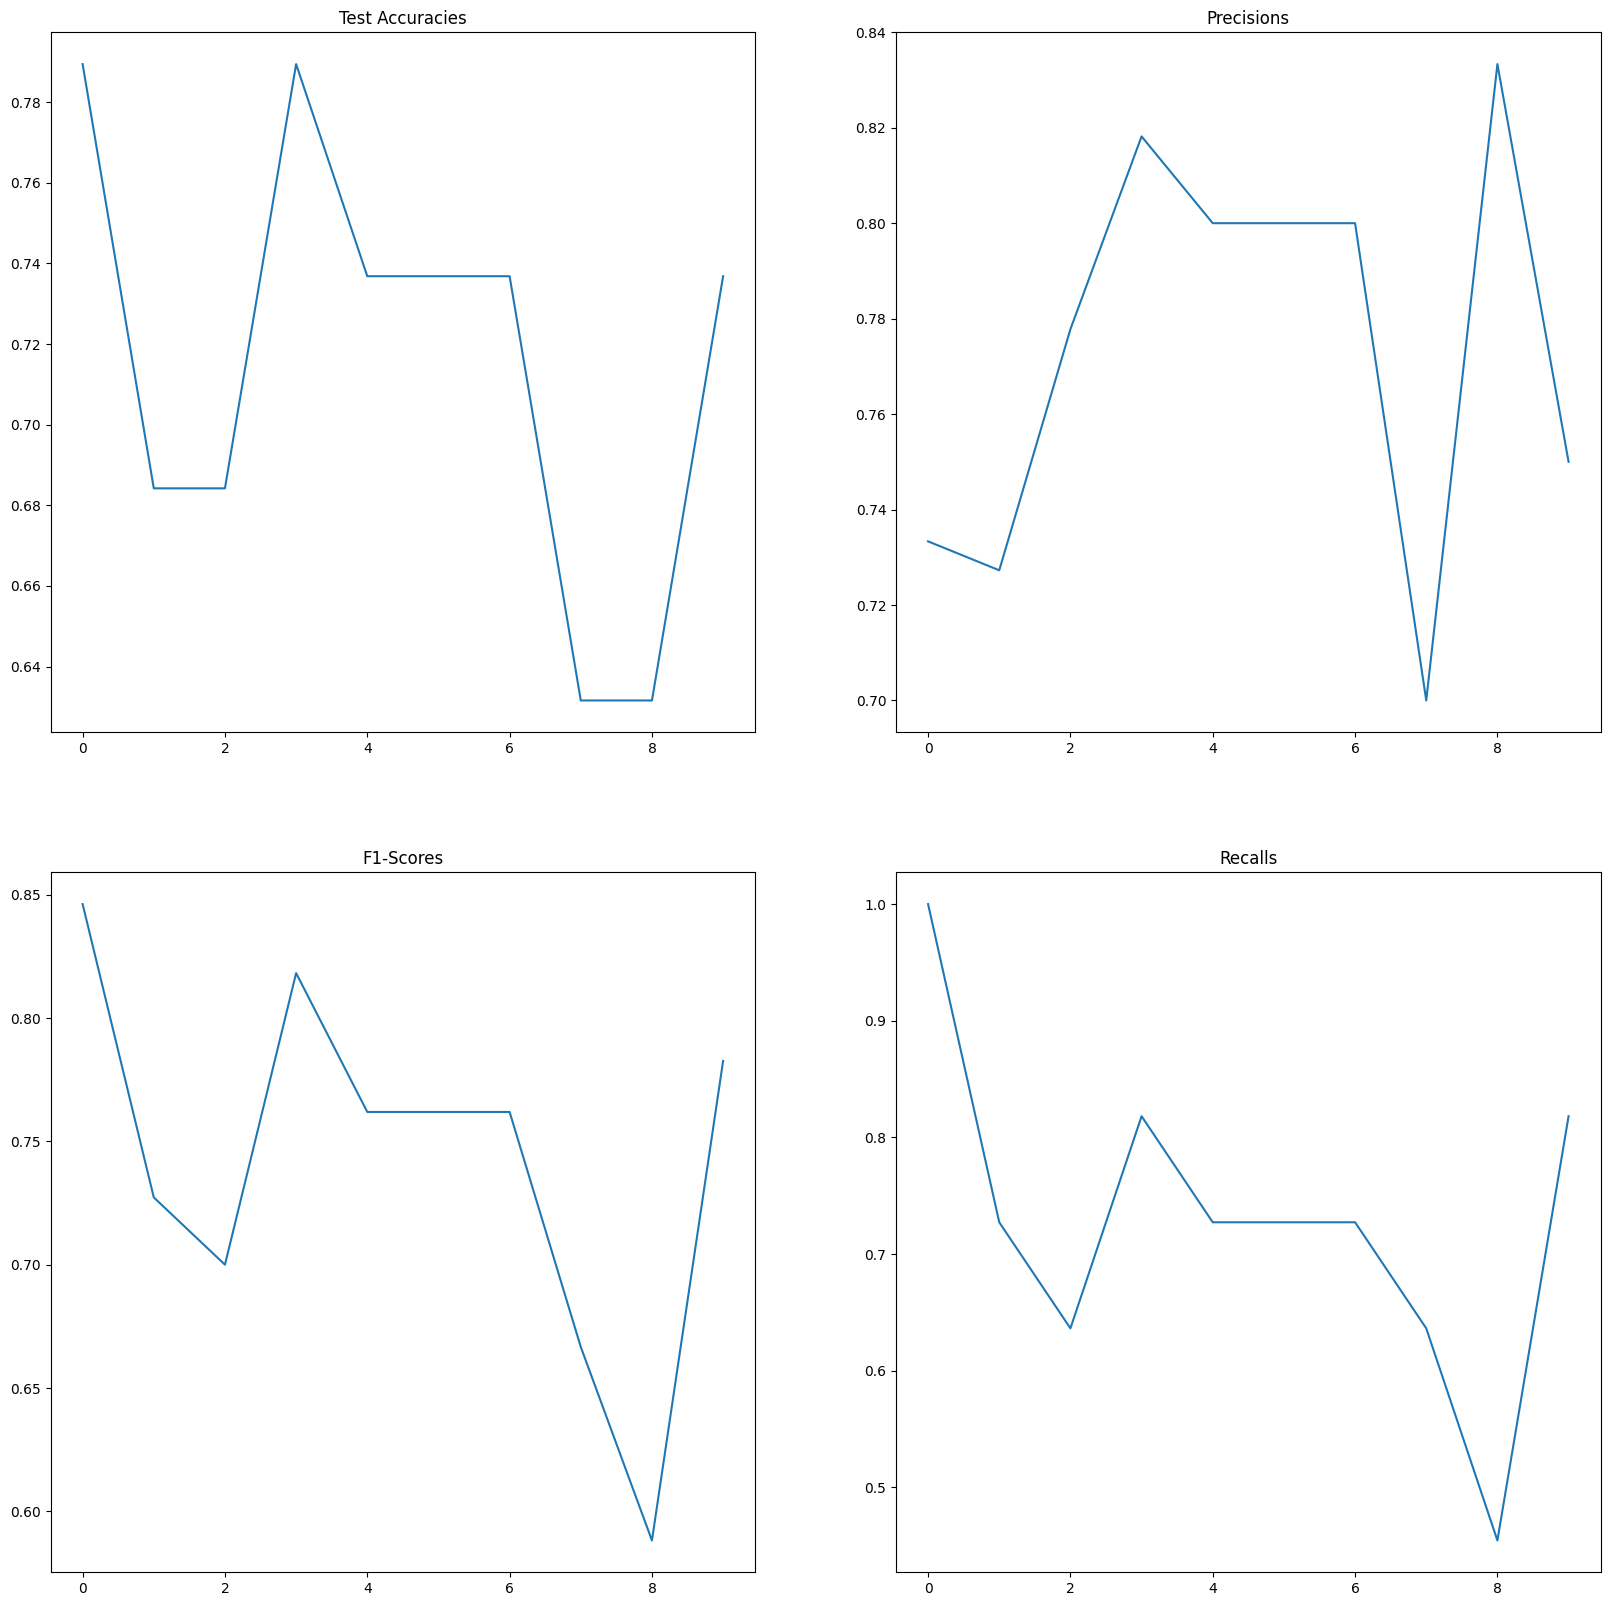

In [22]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_sequences, train_labels, batch_size=4, epochs=10,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()



In [23]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.773989898989899 +- 0.04171805829762051
Mean Accuracy: 0.7157894736842105 +- 0.05367388961676616
Mean Recall: 0.7272727272727273 +- 0.0
Mean F1 Scores: 0.7414833333759165 +- 0.07126449108520314


### 2.RNN

1/1 [==============================] - 0s 289ms/step


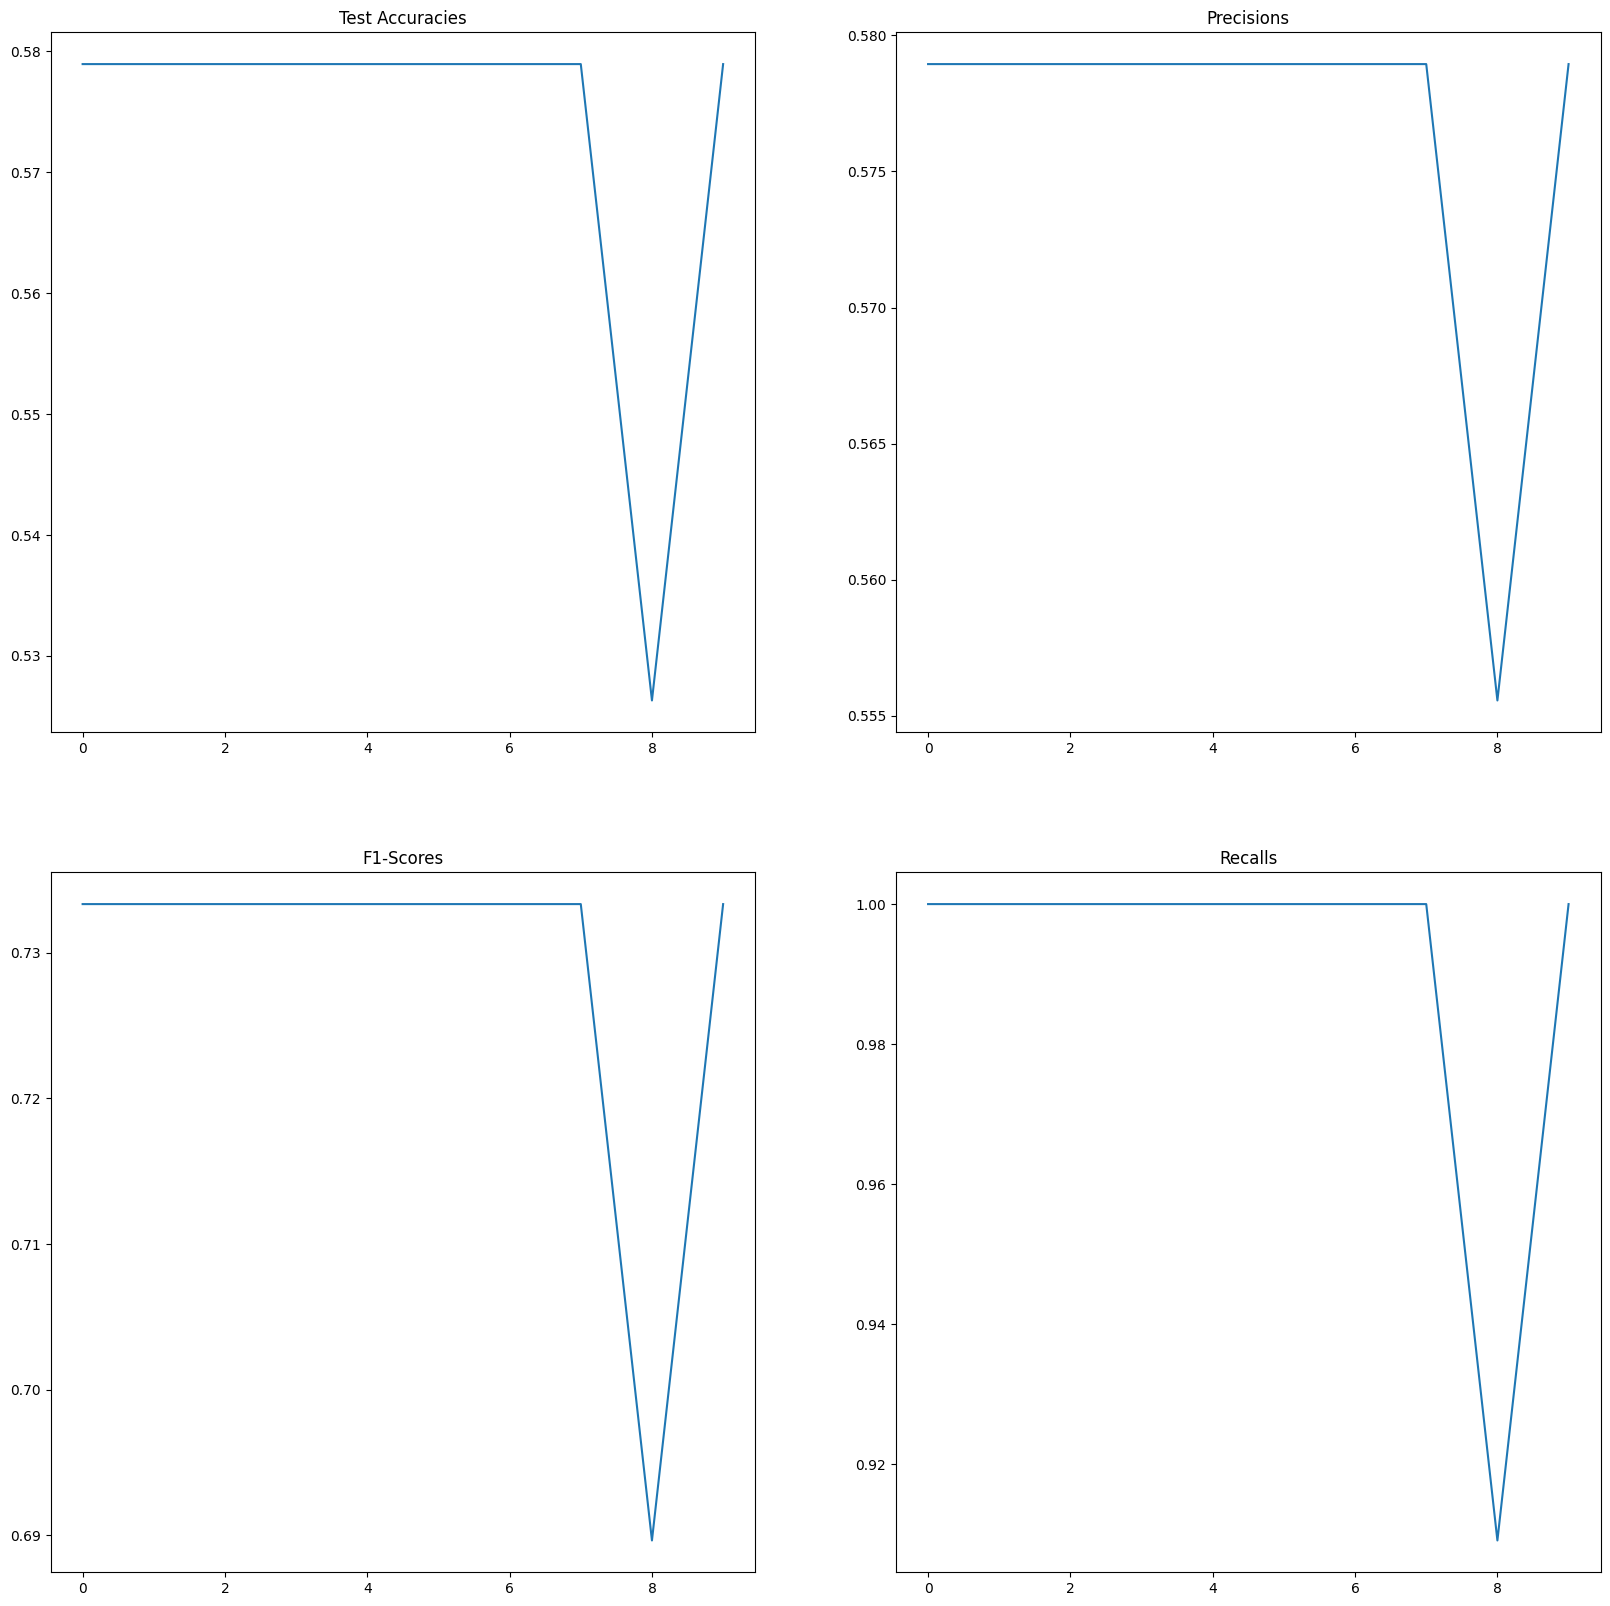

In [24]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_rnn = model_rnn.fit(train_sequences, train_labels, batch_size=4, epochs=10,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_rnn.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [25]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.576608187134503 +- 0.007017543859649122
Mean Accuracy: 0.5736842105263158 +- 0.01578947368421054
Mean Recall: 0.9909090909090909 +- 0.0
Mean F1 Scores: 0.7289655172413794 +- 0.013103448275862073


### 3.LSTM

1/1 [==============================] - 0s 270ms/step


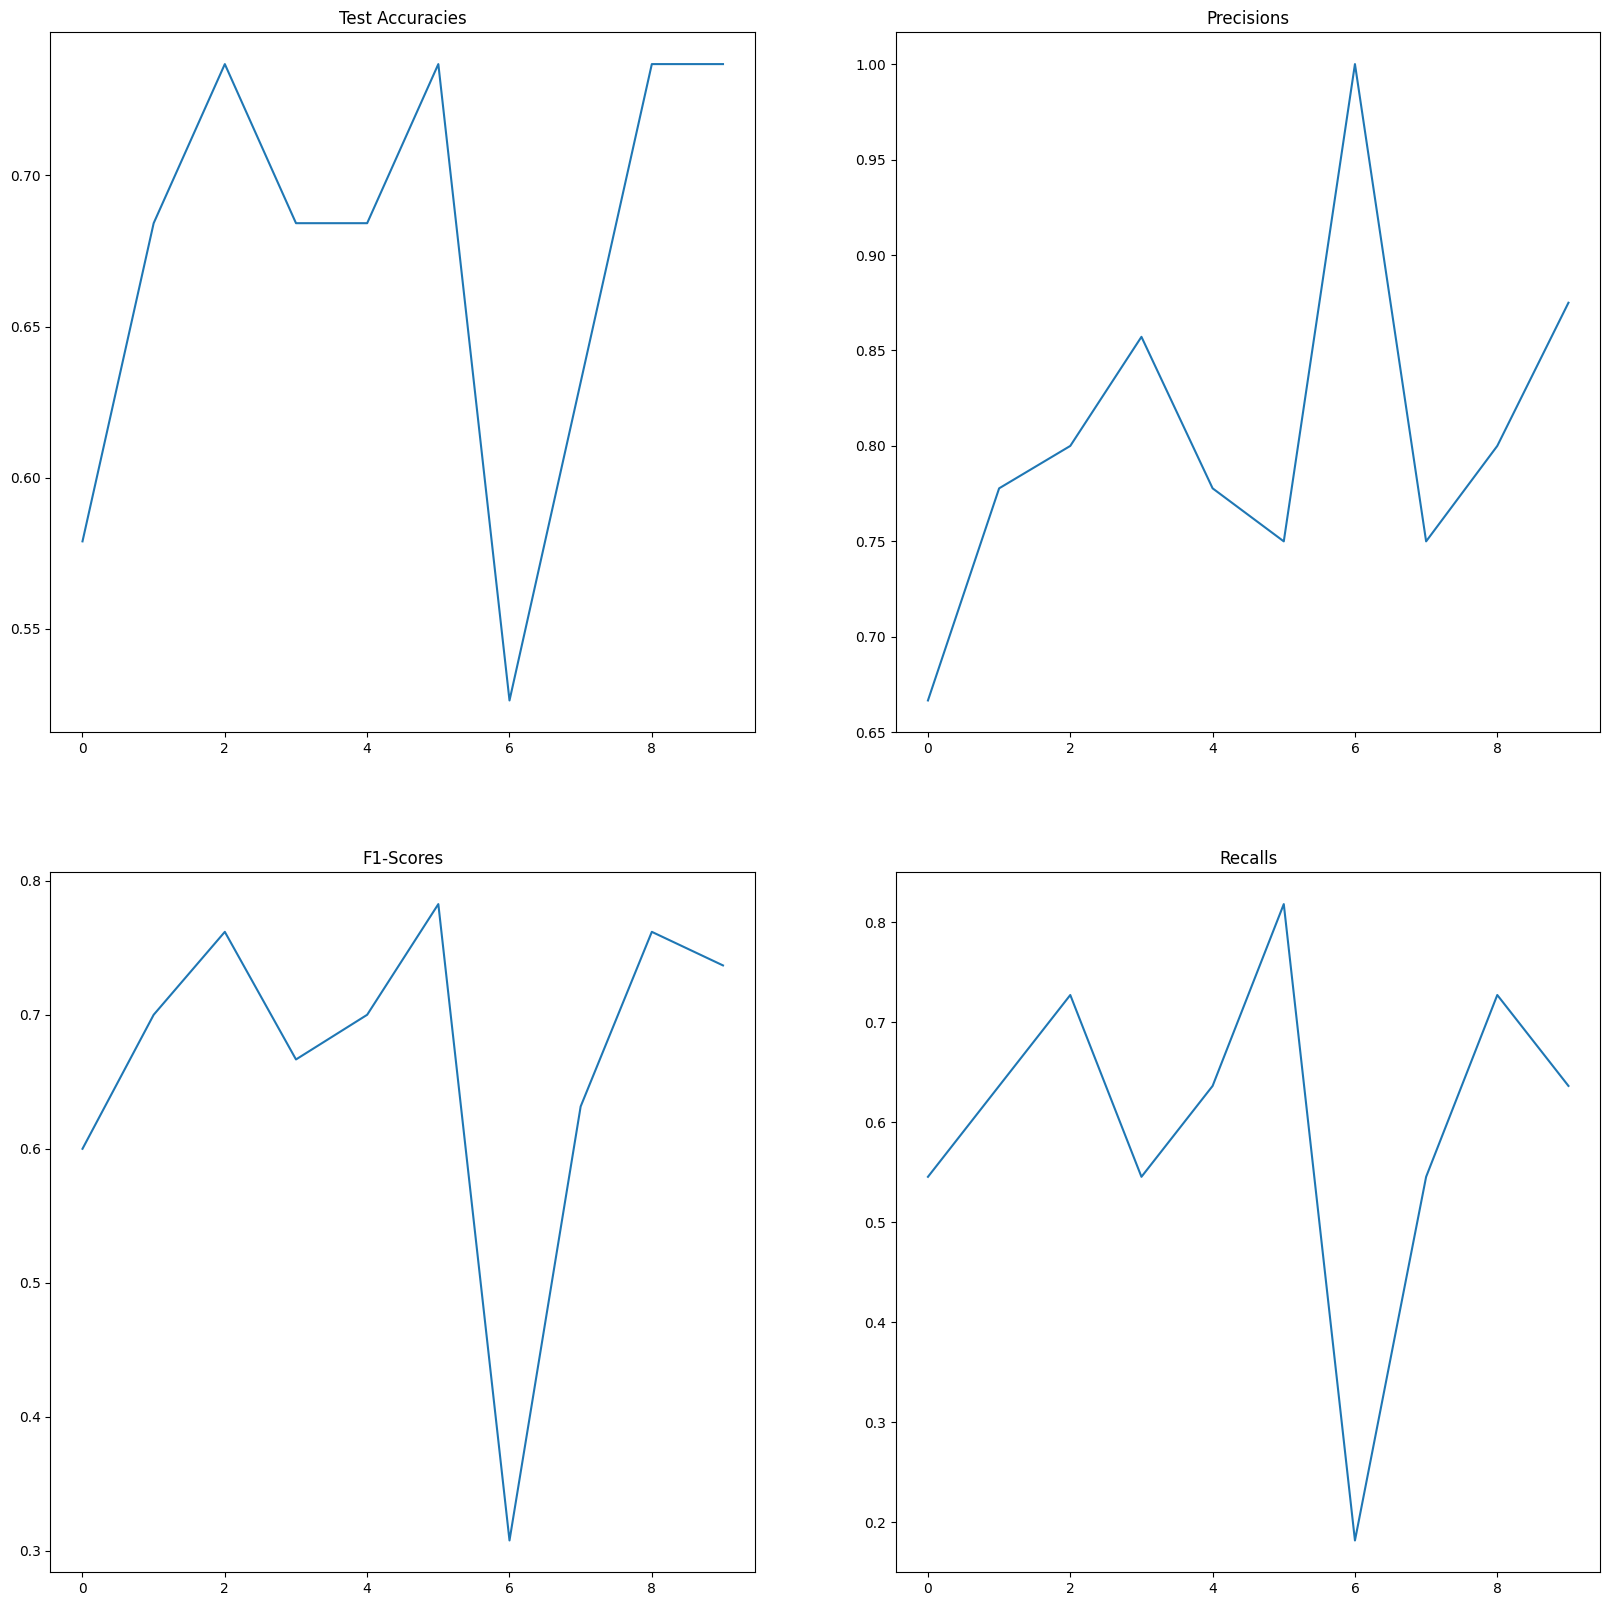

In [26]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_lstm = model_lstm.fit(train_sequences, train_labels, batch_size=4, epochs=10,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_lstm.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [27]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.8054365079365079 +- 0.0850647882709275
Mean Accuracy: 0.6736842105263158 +- 0.06982367979695578
Mean Recall: 0.6 +- 0.0
Mean F1 Scores: 0.664919824645225 +- 0.13161976537718012


### 4.LSTMs with Global Average Pooling

1/1 [==============================] - 0s 274ms/step


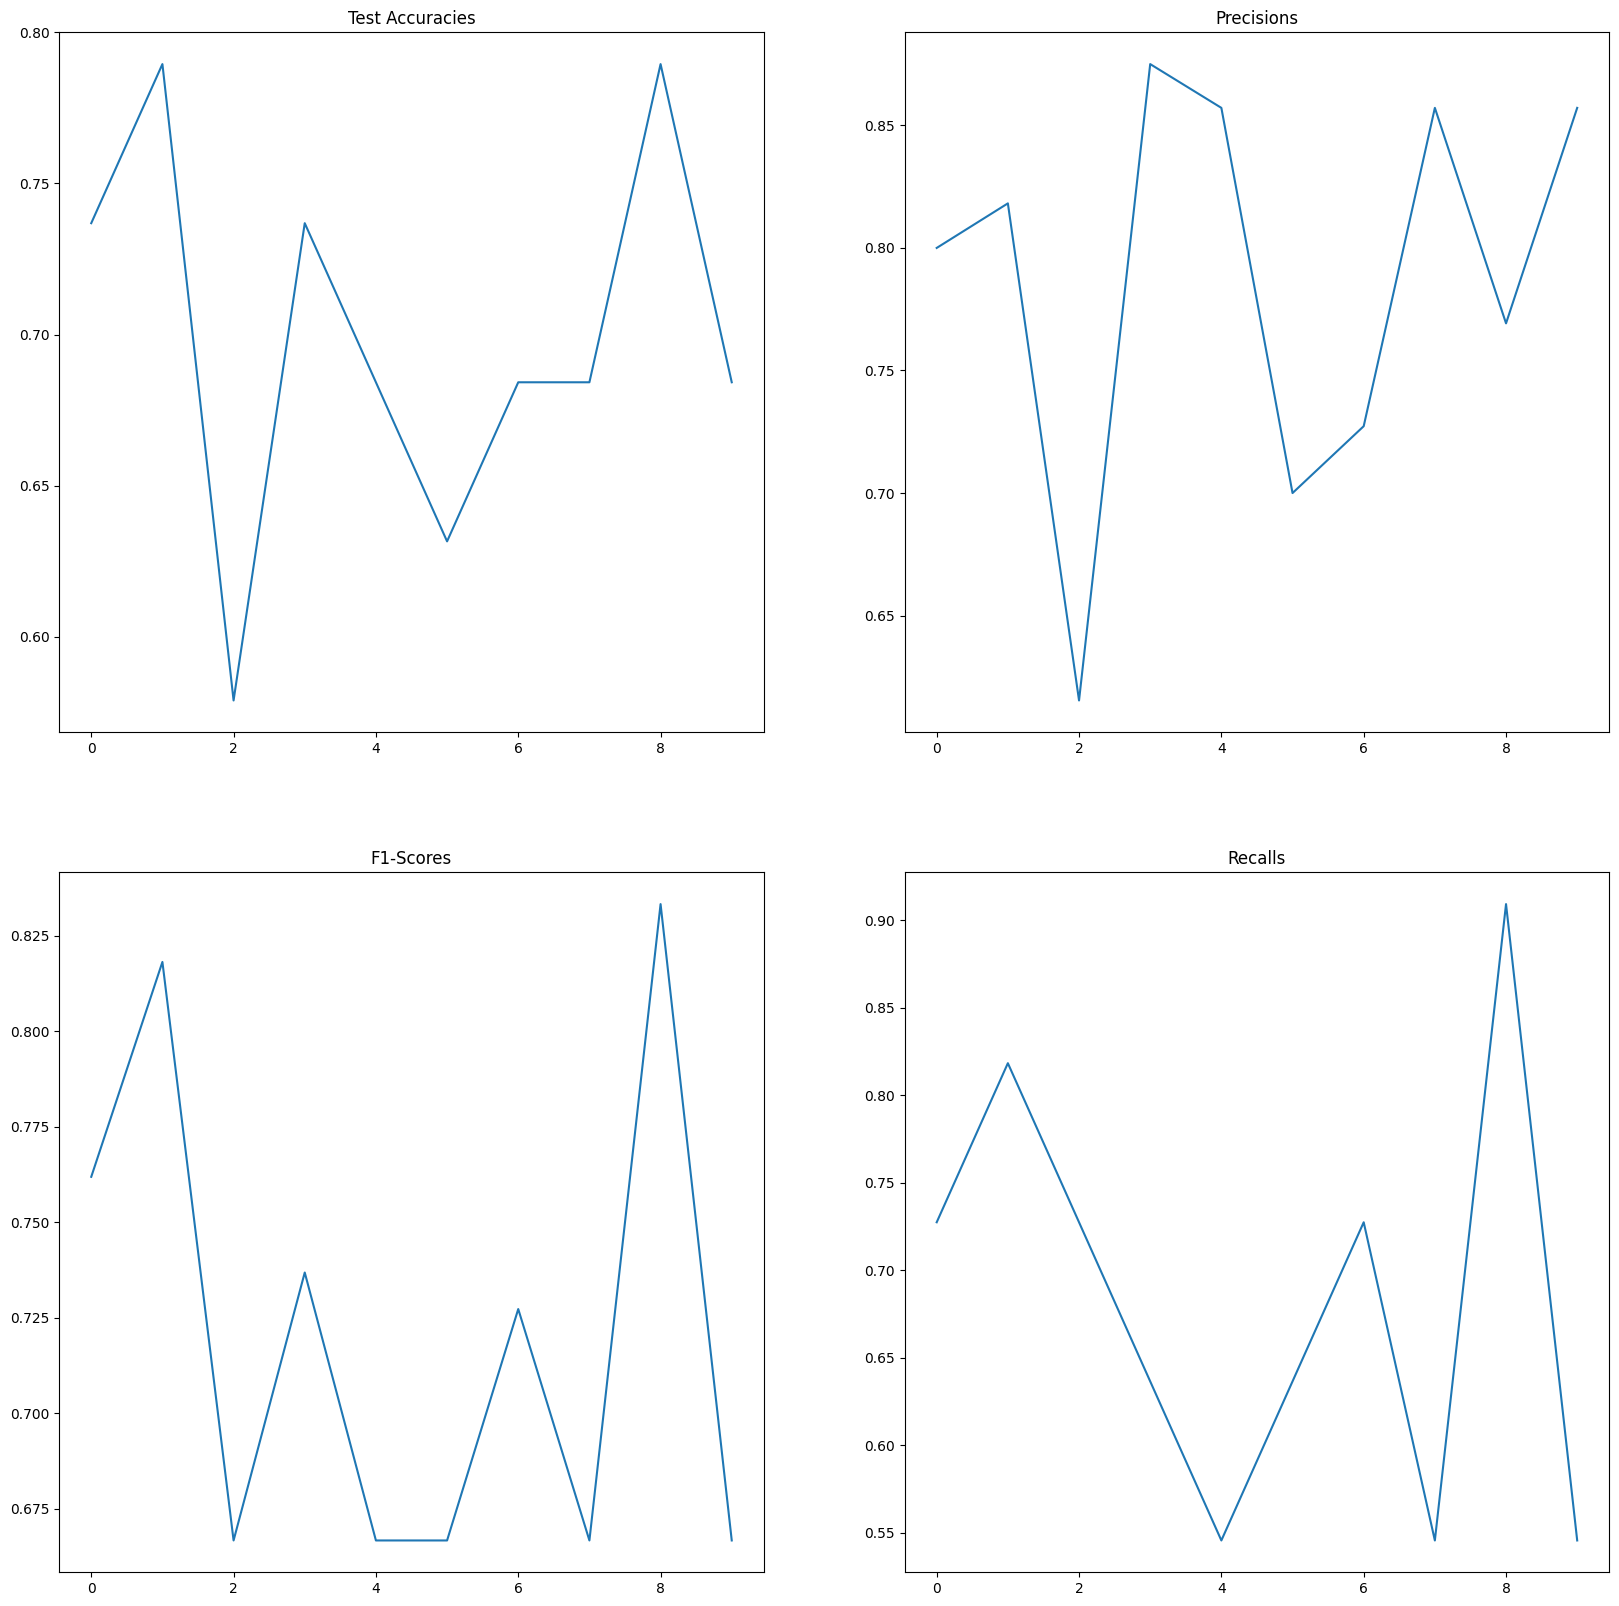

In [28]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_lstm_avg = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_lstm_avg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_lstm_avg = model_lstm_avg.fit(train_sequences, train_labels, batch_size=4, epochs=10,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_lstm_avg.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [29]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.7876498501498501 +- 0.08033995074911095
Mean Accuracy: 0.7 +- 0.06249653730019956
Mean Recall: 0.6818181818181819 +- 0.0
Mean F1 Scores: 0.7210868079289131 +- 0.06227927642112132


### 5. LSTM with only one FC Dense Layer

1/1 [==============================] - 0s 384ms/step


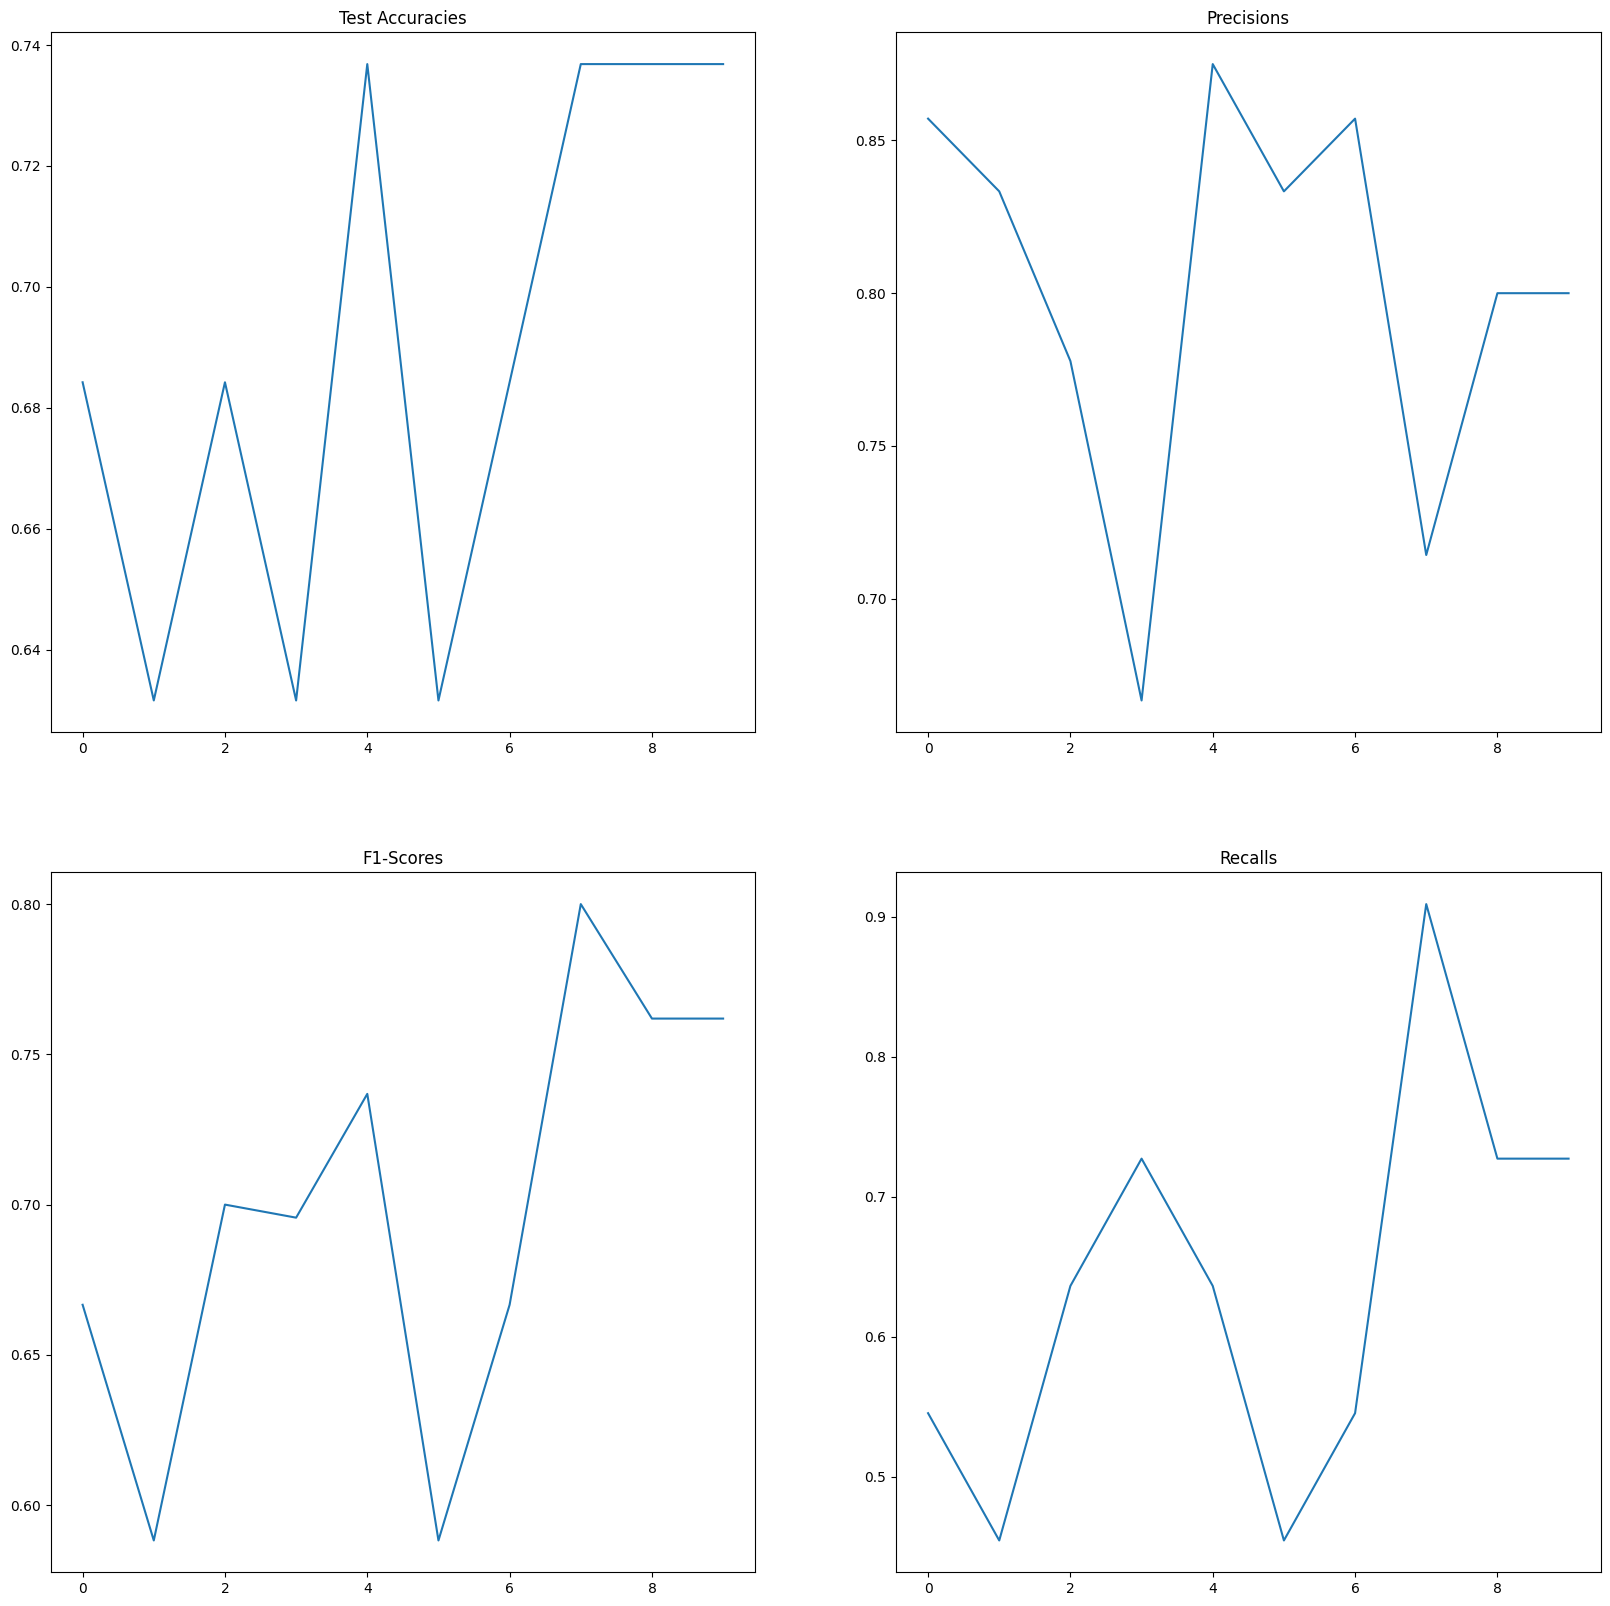

In [30]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_lstm1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_lstm1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_lstm1 = model_lstm1.fit(train_sequences, train_labels, batch_size=4, epochs=10,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_lstm1.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [31]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.8014682539682539 +- 0.06322564391427664
Mean Accuracy: 0.6894736842105262 +- 0.0437190729627267
Mean Recall: 0.6363636363636365 +- 0.0
Mean F1 Scores: 0.6966107724554352 +- 0.06791958182700049


### 6. STACKED LSTM

1/1 [==============================] - 0s 459ms/step


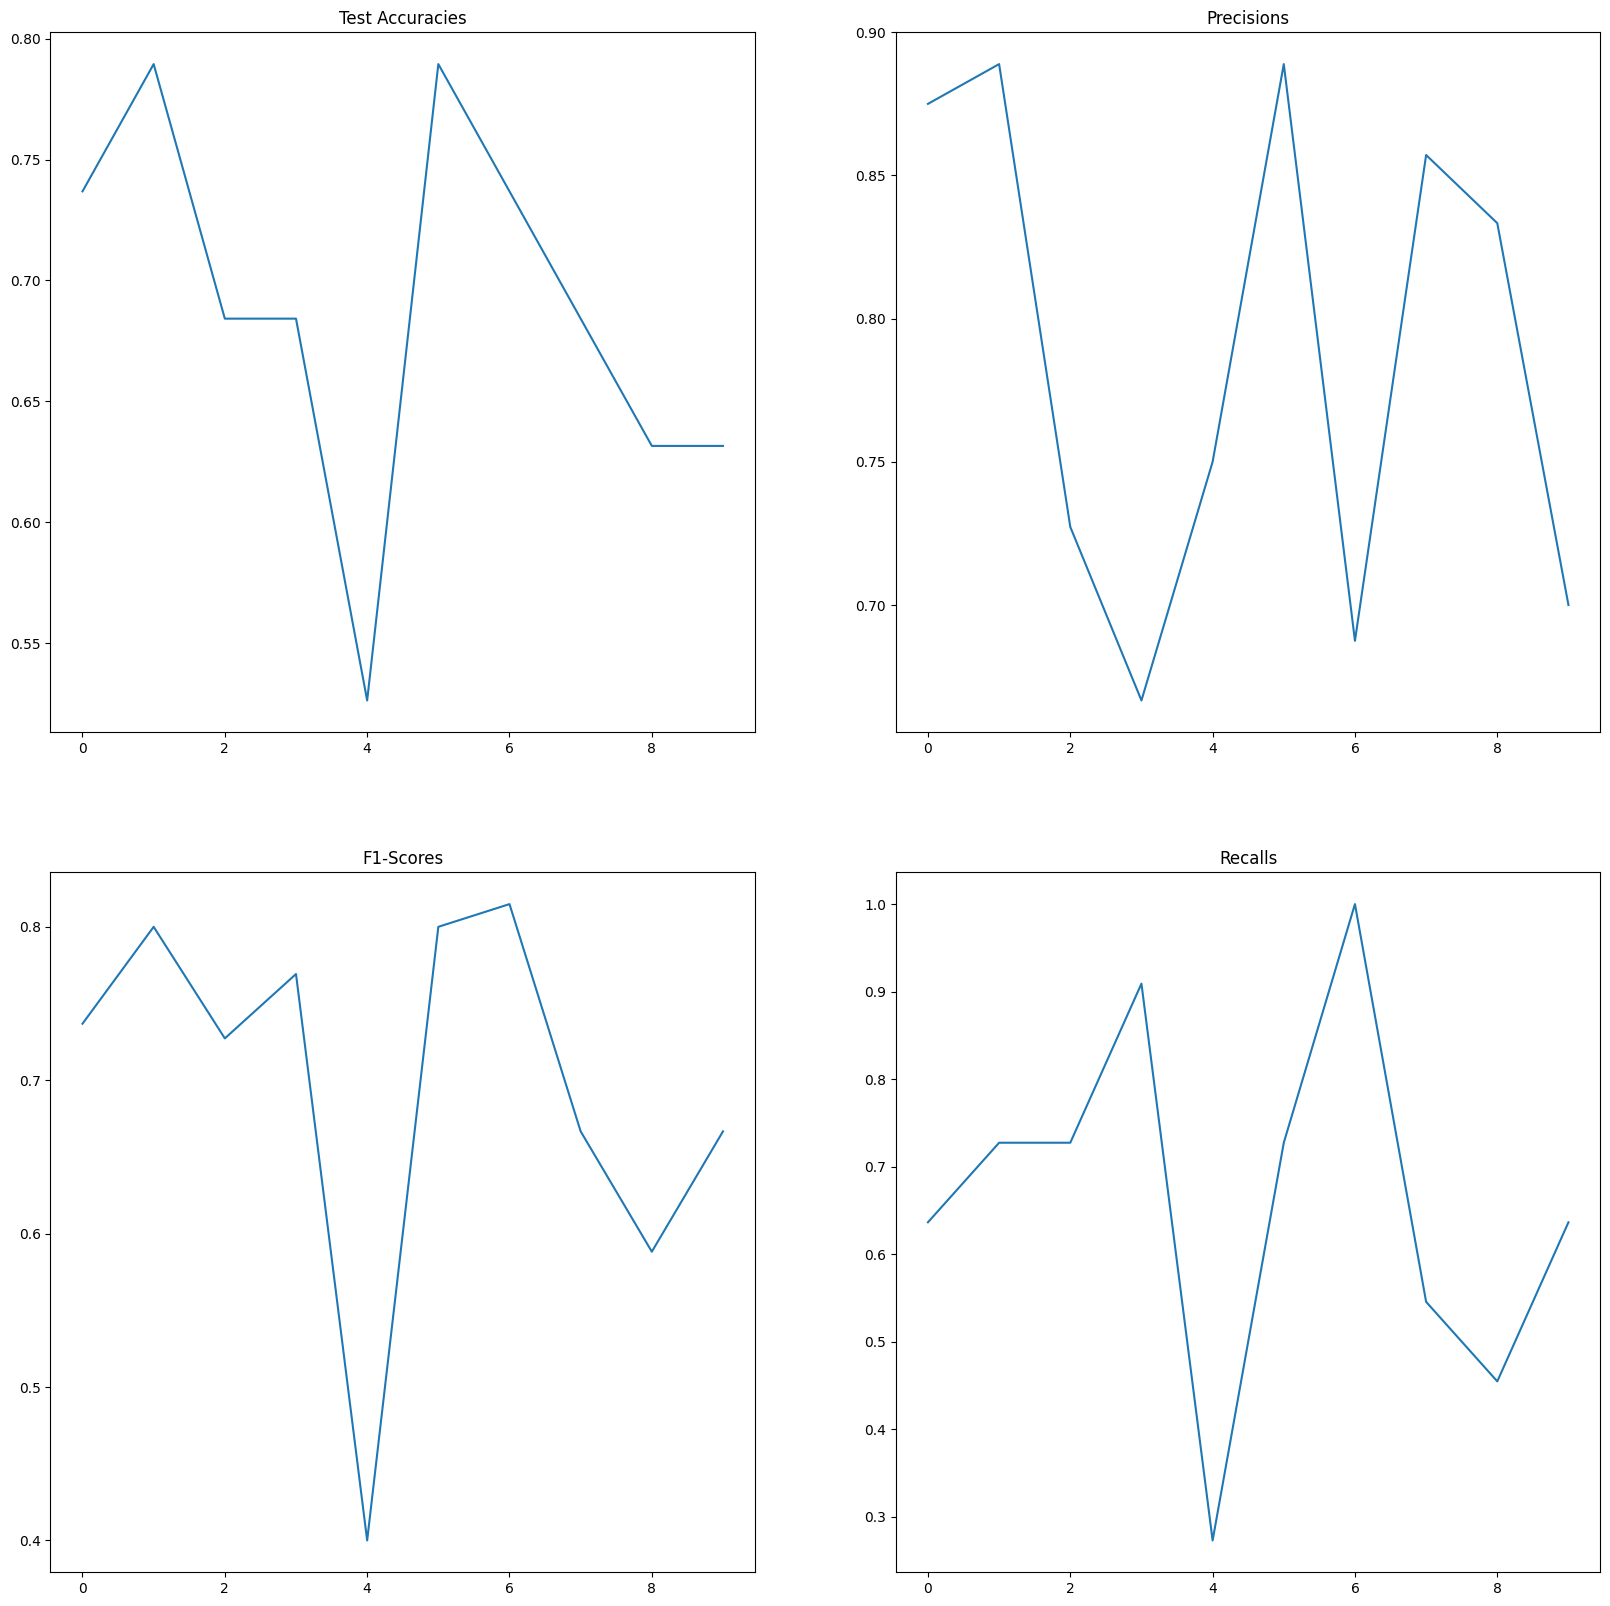

In [32]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_st_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_st_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_st_lstm = model_st_lstm.fit(train_sequences, train_labels, batch_size=4, epochs=10,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_st_lstm.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [33]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.7874693362193362 +- 0.08512167467669268
Mean Accuracy: 0.6894736842105263 +- 0.07608859102526822
Mean Recall: 0.6636363636363636 +- 0.0
Mean F1 Scores: 0.6969729044032449 +- 0.12029065720496772


### 7. GRU

1/1 [==============================] - 0s 467ms/step


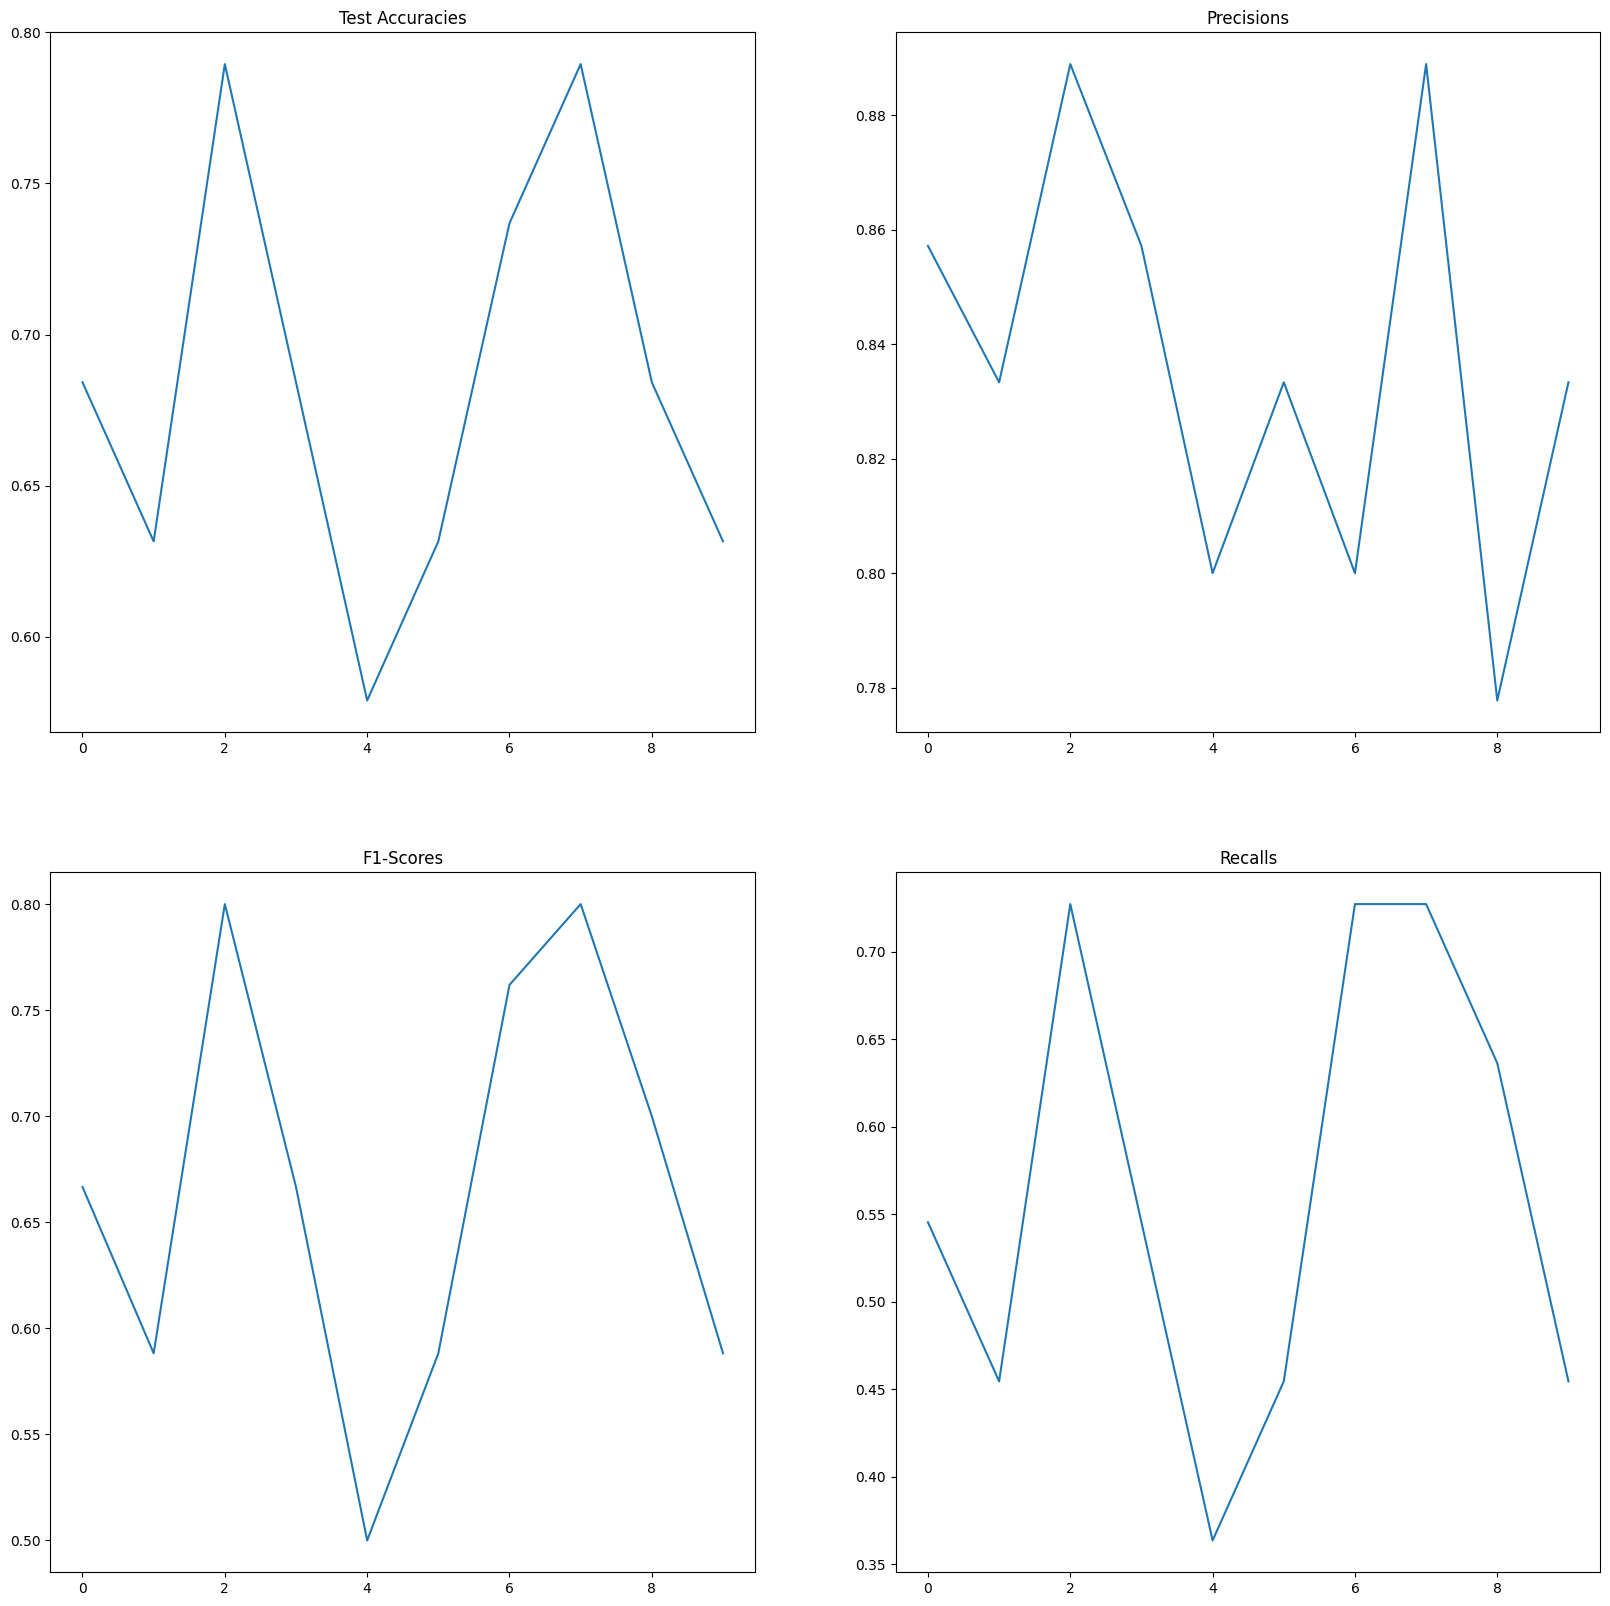

In [34]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_gru = model_gru.fit(train_sequences, train_labels, batch_size=4, epochs=10,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_gru.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [35]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.836984126984127 +- 0.03532985336333462
Mean Accuracy: 0.6842105263157895 +- 0.06657426652986062
Mean Recall: 0.5636363636363636 +- 0.0
Mean F1 Scores: 0.6659943977591036 +- 0.09589820664327016


### 8. BiLSTM

1/1 [==============================] - 1s 809ms/step


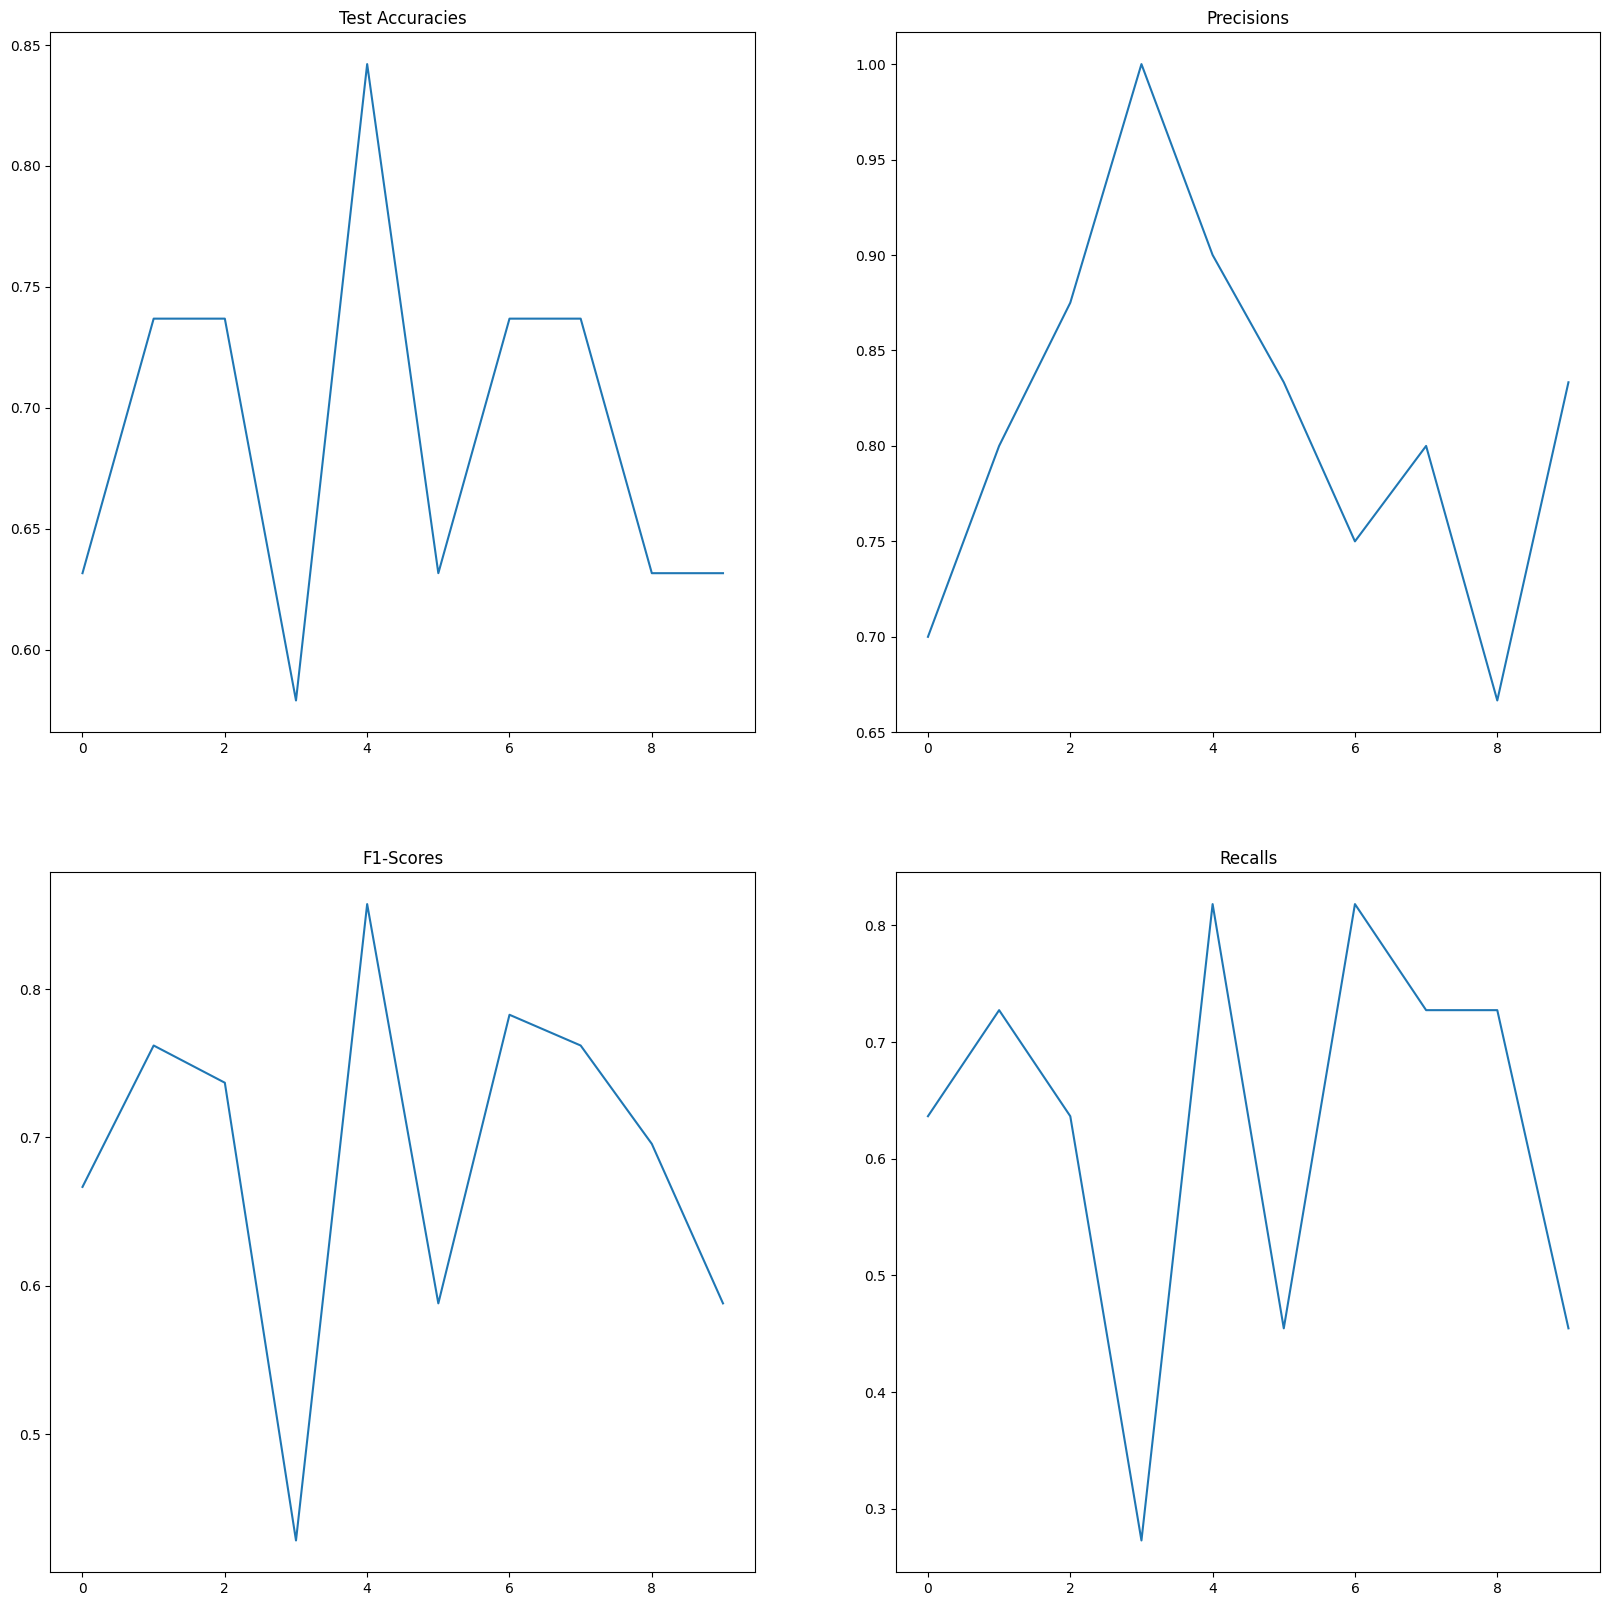

In [36]:
runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    model_bidir = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_bidir = model_bidir.fit(train_sequences, train_labels, batch_size=4, epochs=10,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model_bidir.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()

In [37]:
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))

Mean Precision: 0.8158333333333333 +- 0.09253002515700272
Mean Accuracy: 0.6894736842105263 +- 0.0760885910252682
Mean Recall: 0.6272727272727273 +- 0.0
Mean F1 Scores: 0.6867764039254146 +- 0.11771888637029085


### 9. Transformer

1/1 [==============================] - 2s 2s/step


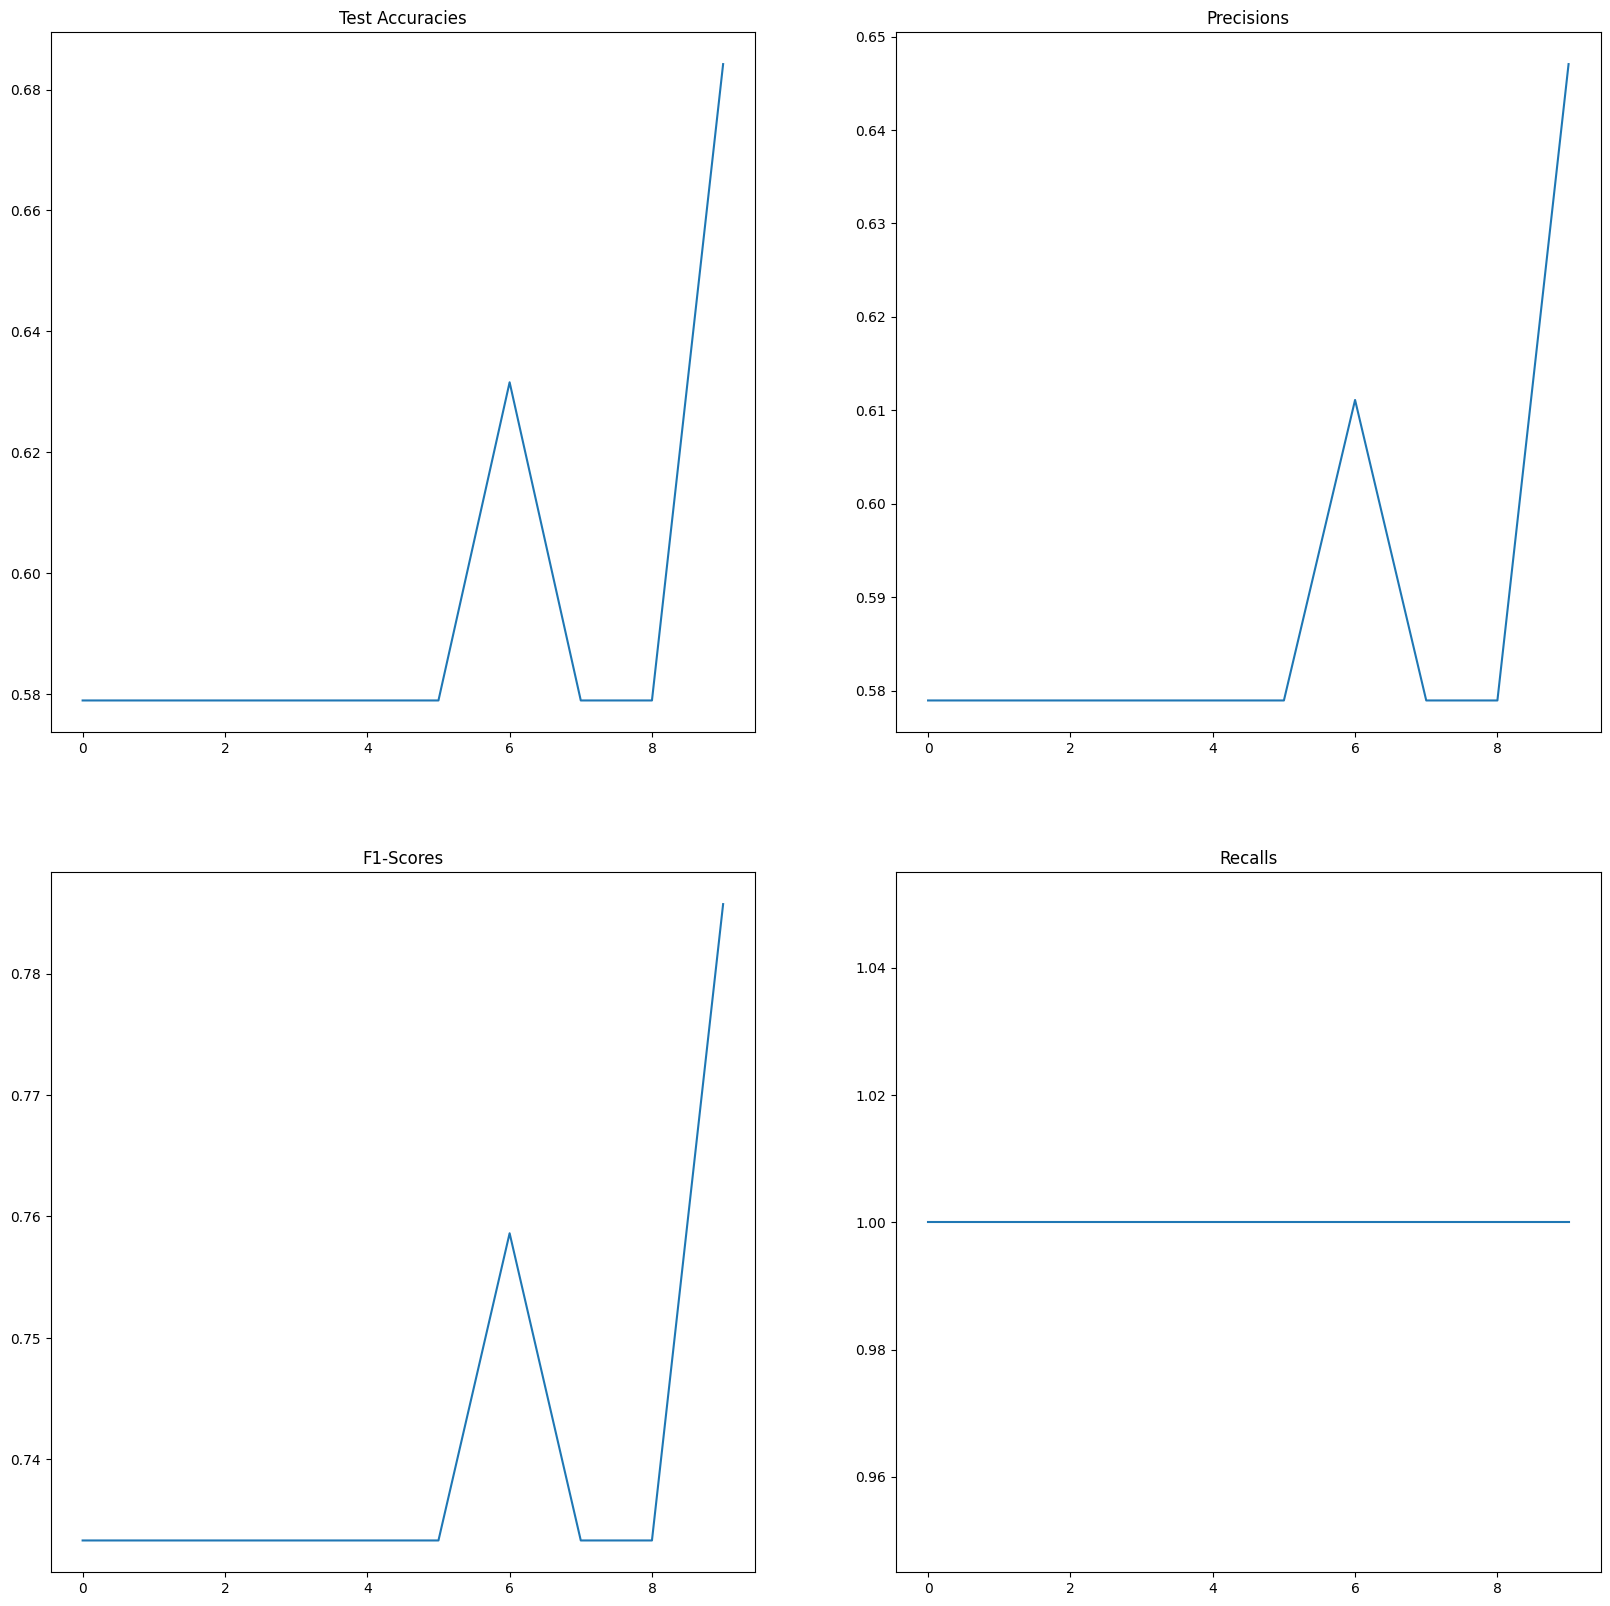

Mean Precision: 0.5889748882008944 +- 0.021605936988381542
Mean Accuracy: 0.5947368421052632 +- 0.03370065388122551
Mean Recall: 1.0 +- 0.0
Mean F1 Scores: 0.7411001642036126 +- 0.016673265860076867


In [38]:
from tensorflow import keras
from tensorflow.keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

embed_dim = 64  # Embedding size for each token
vocab_size = 20000
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 60
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

runs = np.arange(10)
precisions = []
accuracies = []
recalls = []
f1scores = []

for _ in range(10):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)


    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                        validation_data=(test_sequences, test_labels),
                        callbacks=[rlrp] ,verbose=0)
    y_pred = model.predict(test_sequences)

# Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(test_labels, y_pred_binary)
    recall = recall_score(test_labels, y_pred_binary)
    f1 = f1_score(test_labels, y_pred_binary)
    accuracy = accuracy_score(test_labels, y_pred_binary)

    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1)
    accuracies.append(accuracy)

plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(runs,accuracies)
plt.title('Test Accuracies')

plt.subplot(2,2,2)
plt.plot(runs,precisions)
plt.title("Precisions")

plt.subplot(2,2,3)
plt.plot(runs,f1scores)
plt.title('F1-Scores')

plt.subplot(2,2,4)
plt.plot(runs,recalls)
plt.title('Recalls')

plt.show()
print("Mean Precision: "+  str(np.mean(precisions))+ " +- " + str(np.std(precisions)))
print("Mean Accuracy: "+ str(np.mean(accuracies)) + " +- " + str(np.std(accuracies)))
print("Mean Recall: "+ str(np.mean(recalls))+ " +- " + str(np.std(recall)))
print("Mean F1 Scores: "+ str(np.mean(f1scores)) + " +- " + str(np.std(f1scores)))